# Phase 5: Threshold Optimization
#### **Objective:**
Optimize the decision threshold for the **_final classification model (XGBoost)_** to:
* Maximize recall or precision depending on risk telerance
* Reduce **_false positives_** without missing true risks
* Serve **_as a tuning guide for compliance officers_** using the API or Power BI
#### **Outcome:**
* A visual decision guide for model threshold tuning
* A numeric recommendation for:
    * Threshold for deployment (used in `/predict_match`)
    * Threshold to monitor via Power BI
* threshold_curve.csv for export to BI or future analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.metrics import precision_recall_curve, roc_curve

# Load saved model
model = joblib.load("../models/xgb_sanction_model.pkl")

# Load prepared test data
df = pd.read_csv("../data/sanctions_features.csv")
df = df[df["fuzz_ratio_reference"].notna()].copy()
df["is_match"] = ((df["fuzz_ratio"] > 50) | (df["common_token_count"] > 0)).astype(int)

X = df.drop(columns=["is_match", "cleaned_name", "fuzz_ratio_reference"])
y = df["is_match"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

y_scores = model.predict_proba(X_test)[:, 1]

#### **Plot precision-recall and F1 vs Threshold**

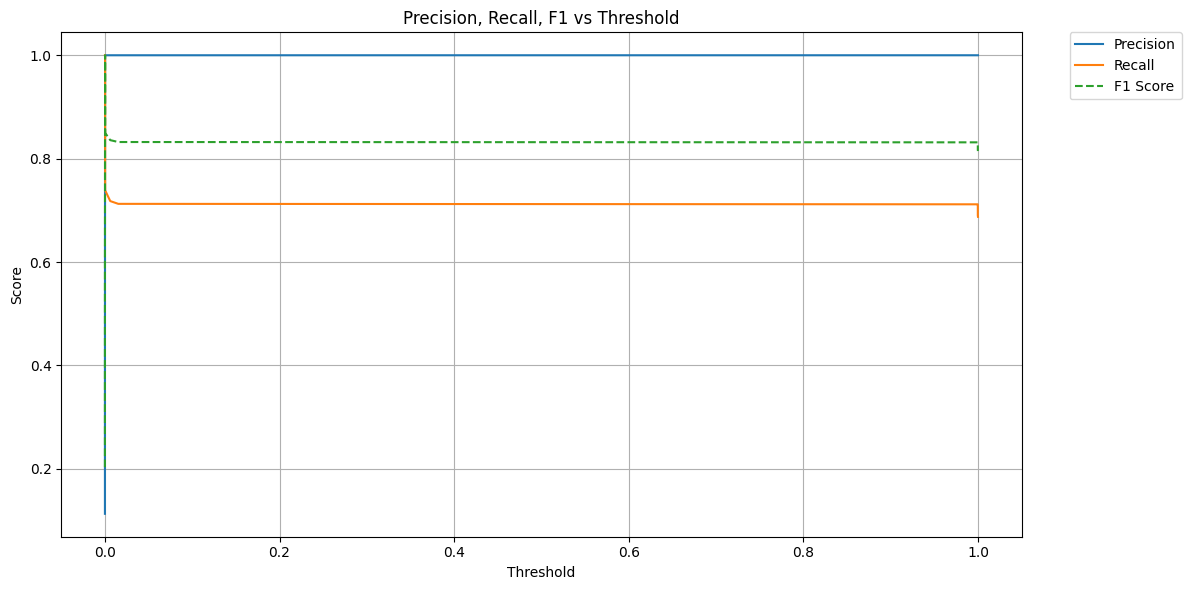

In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score

precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

f1s = [2 * (p * r) / (p + r) if (p + r) > 0 else 0
       for p, r in zip(precisions, recalls)]

plt.figure(figsize=(12, 6))

plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.plot(thresholds, f1s[:-1], label="F1 Score", linestyle="--")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, F1 vs Threshold")
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0
)
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Recommend Optimal Threshold**
Choose based on domain needs:

In [3]:
threshold_df = pd.DataFrame({
    "threshold": thresholds,
    "precision": precisions[:-1],
    "recall": recalls[:-1],
    "f1": f1s[:-1]
})

best_f1 = threshold_df.loc[threshold_df["f1"].idxmax()]
best_precision_90r = threshold_df[threshold_df["precision"] >= 0.90].iloc[0]

print(f"📌 Best F1 Threshold: {best_f1["threshold"]}")
print(f"📌 Threshold for ≥90% Recall: {best_precision_90r["threshold"]}")

📌 Best F1 Threshold: 0.00018276157788932323
📌 Threshold for ≥90% Recall: 0.00018276157788932323


In [4]:
threshold_df.to_csv("../data/threshold_df.csv", index=False)